In [48]:
import torch
import torch.nn.functional as F

from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torchio as tio
import nibabel as nib
import SimpleITK as sitk
from scipy.stats import iqr
from scipy.stats import f_oneway

import os
import json
import numpy as np
import copy
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import torchvision
from torchvision import models
from torchvision import transforms

import yaml
from dataset.hmri_dataset import HMRIDataModule, HMRIDataModuleDownstream
from models.pl_model import Model, ContrastiveLearning, ModelDownstream
from utils.utils import get_pretrained_model
from utils.utils import save_nifti_from_array, crop_img
from utils.general_utils import save_sitk_from_nda
this_path = Path().resolve()

In [61]:
df_bids = pd.read_csv('/mrhome/alejandrocu/Documents/parkinson_classification/bids_3t.csv')

In [62]:
df_bids.loc[df_bids.group == 'PD', 'sex'].

1    49
0    23
Name: group, dtype: int64

In [63]:
def mask_atlas(subject:str, group: str, save=True):
    anat_path = Path(f'/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/Masks')
    # read brain mask
    brain_mask = sitk.GetArrayFromImage(sitk.ReadImage(str(anat_path/f'{subject}_brain_mask_mtsat_w.nii')))

    x_min, x_max, y_min, y_max, z_min, z_max = crop_img(brain_mask, return_dims=True)

    # read atlas
    atlas = sitk.ReadImage(str(anat_path/f'inv_reoriented_{subject}_mT1w_{group}_pd25_PD25-subcortical-1mm_uint8.nii'))
    atlas_nda = sitk.GetArrayFromImage(atlas)
    # crop atlas
    atlas_nda_c = atlas_nda[x_min:x_max, y_min:y_max, z_min:z_max] 
    if save:
        save_sitk_from_nda(atlas_nda_c,
                           anat_path/f'{subject}_PD25-subcortical-1mm_cropped.nii',
                           atlas)
    else:
        return atlas_nda_c

def get_atlas_nda(subject, group):

    # crop PD25 atlas as brain mask and save
    mask_atlas(subject, group)
    og_path = Path(f"/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI/{subject}/Results/")
    
    # set atlas path
    pd25_path = og_path / f'Masks/{subject}_PD25-subcortical-1mm_cropped.nii'
    
    # create tio subject and preprocess
    preprocess = tio.Compose(
            [   tio.ToCanonical(),
                tio.CropOrPad(180, padding_mode='minimum')
            ]
        )
    atlas_tiosubj_o = tio.Subject(image=tio.ScalarImage(pd25_path))
    atlas_tiosubj_p = preprocess(atlas_tiosubj_o)
    atlas_tiosubj_nda = atlas_tiosubj_p['image'][tio.DATA].cpu().numpy()[0]

    return atlas_tiosubj_nda
    

In [64]:
def get_statistics_from_map(xai_map: np.ndarray, subject: str, group: str):
    # get atlas nda
    atlas_nda = get_atlas_nda(subject, group)
    # get unique values in atlas
    atlas_vals = np.unique(atlas_nda)
    stats = []
    for label in atlas_vals:
        map_stats = {}
        map_stats['label'] = label
        map_stats['group'] = group
        map_stats['subject'] = subject     
        masked_map = xai_map[atlas_nda == label]
        map_stats['mean'] = np.mean(masked_map)
        map_stats['std'] = np.std(masked_map)
        map_stats['median'] = np.median(masked_map)
        map_stats['max'] = np.max(masked_map)
        map_stats['min'] = np.min(masked_map)
        map_stats['iqr'] = iqr(masked_map)
        stats.append(map_stats)

    return pd.DataFrame(stats)

In [8]:
subject = 'sub-015'
pilot_path = Path(f"/mrhome/alejandrocu/Documents/parkinson_classification/xai_outs/{subject}/occ_sens/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01")
img_can = nib.load(str(pilot_path/'sub-015_R2s_WLS1_ps5_stride3_og_img.nii.gz')).get_fdata()
df = get_statistics_from_map(img_can, subject)
df['map_type'] = 'R2s'
df['group'] = 'PD'

In [65]:
# subjs = {'sub-041': 'PD',
#          'sub-036': 'HC',
#          'sub-035': 'PD',
#          'sub-071': 'PD',
#          'sub-030': 'HC',
#          'sub-015': 'PD',
#          'sub-032': 'HC',
#          'sub-050': 'HC'}
subjs = {'sub-021': 'PD',
         'sub-064': 'HC',
         'sub-042': 'PD',
         'sub-066': 'PD',
         'sub-039': 'PD'}

maps = ['r2s', 'occ', 'ig']
dfs = pd.DataFrame()
for subject, group in subjs.items():
    for xai_map in maps:
        base_path = Path(f'/mrhome/alejandrocu/Documents/parkinson_classification/xai_outs/{subject}')
        if xai_map == 'r2s':
            map_path = base_path / f'occ_sens/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01/{subject}_R2s_WLS1_ps5_stride3_og_img.nii.gz'
        elif xai_map == 'occ':
            map_path = base_path / f'occ_sens/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01/{subject}_R2s_WLS1_ps5_stride3_occ_result.nii.gz'
        elif xai_map == 'ig':
            map_path = base_path / f'grad_based/4A_hMRI_R2s_WLS1_optim_adam_lr_0.01/{subject}_R2s_WLS1_IntegratedGrads_nsteps_200_result.nii.gz'
        map_img = nib.load(str(map_path)).get_fdata()
        df = get_statistics_from_map(map_img, subject, group)
        df['map_type'] = xai_map
        dfs = pd.concat([dfs, df], axis=0)
    # break
dfs.reset_index(drop=True, inplace=True)
dfs


,label,group,subject,mean,std,median,max,min,iqr,map_type
0,0,PD,sub-021,0.073175,0.159834,0.000000,1.000000,0.000000,0.000000,r2s
1,1,PD,sub-021,0.556251,0.137773,0.540562,0.972508,0.311592,0.172323,r2s
2,2,PD,sub-021,0.589647,0.124017,0.571411,0.943677,0.341132,0.168418,r2s
3,3,PD,sub-021,0.657735,0.220869,0.630668,1.000000,0.190870,0.384007,r2s
4,4,PD,sub-021,0.689894,0.267532,0.731393,1.000000,0.137779,0.535777,r2s
...,...,...,...,...,...,...,...,...,...,...
250,12,PD,sub-039,0.000010,0.000008,0.000008,0.000053,-0.000002,0.000010,ig
251,13,PD,sub-039,-0.000002,0.000003,-0.000001,0.000008,-0.000021,0.000004,ig
252,14,PD,sub-039,0.000004,0.000003,0.000003,0.000017,-0.000002,0.000005,ig
253,15,PD,sub-039,-0.000003,0.000003,-0.000002,0.000005,-0.000027,0.000003,ig


In [96]:
# df_ex = pd.read_csv('xai_outs/stats_5subjs_others.csv')
# df_ex.drop('Unnamed: 0', axis=1, inplace=True)
# df_ex.to_csv('xai_outs/stats_5subjs_others.csv', index=False)

/tmp/ipykernel_550499/1739611130.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs_uncertain['subgroup'] = 'uncertain'


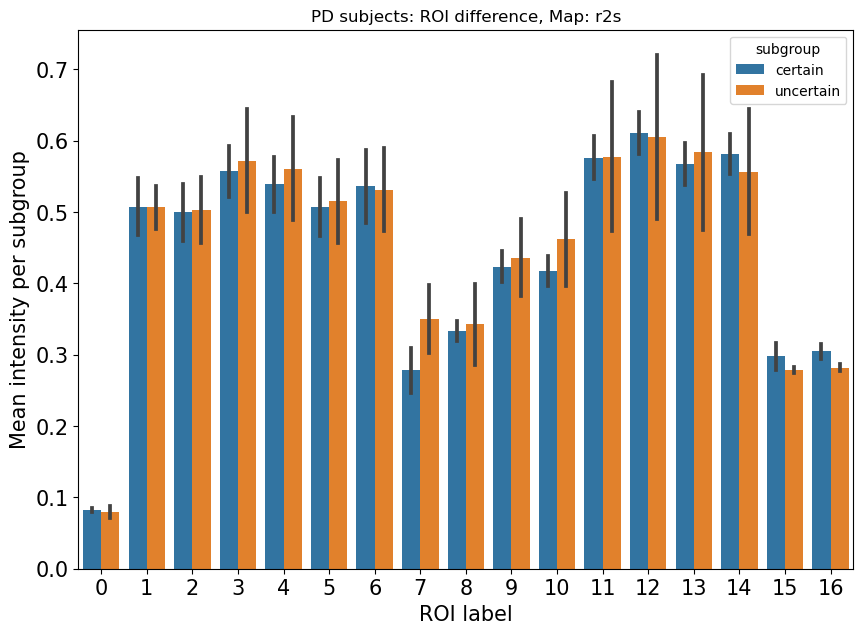

In [116]:
dfs_certain = pd.read_csv('xai_outs/stats_8subj_correct.csv')
dfs_certain = dfs_certain.loc[dfs_certain.group == 'PD']
dfs_certain['subgroup'] = 'certain'
dfs_uncertain = pd.read_csv('xai_outs/stats_5subjs_others.csv')
dfs_uncertain = dfs.loc[dfs.subject.isin(['sub-021', 'sub-042', 'sub-039'])] # correctly classified, close to 0.5 confidence score
dfs_uncertain['subgroup'] = 'uncertain'

map_type = 'r2s'
dfs_all = pd.concat([dfs_certain, dfs_uncertain], axis=0)
df_lab = dfs_all.loc[(dfs_all.map_type == map_type), :]
plt.figure(figsize=(10, 7))
sns.barplot(data=df_lab, x='label', y='mean', hue='subgroup', errorbar='se')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('ROI label', fontsize=15)
plt.ylabel('Mean intensity per subgroup', fontsize=15)
# plt.legend(fontsize=15)
plt.title(f'PD subjects: ROI difference, Map: {map_type}')
plt.show()

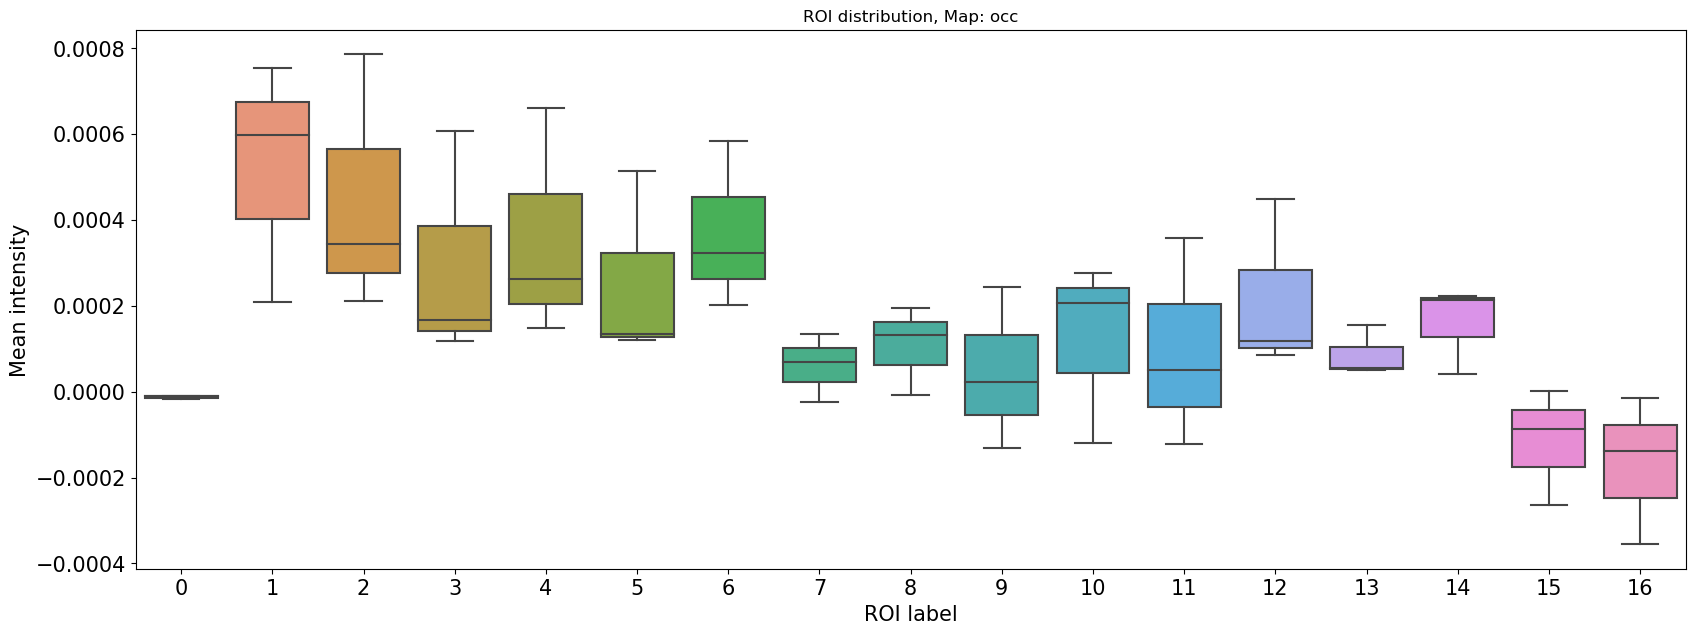

In [68]:
label = 3
map_type = 'occ'
df_lab = dfs_uncertain.loc[(dfs_uncertain.map_type == map_type), :] # & (dfs.map_type == map_type) (dfs.label == label) & 
df_lab
plt.figure(figsize=(20, 7))
sns.boxplot(data=df_lab, x='label', y='mean') #, hue='group') #, hue='map_type')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('ROI label', fontsize=15)
plt.ylabel('Mean intensity', fontsize=15)
# plt.legend(fontsize=15)
plt.title(f'ROI distribution, Map: {map_type}')
plt.show()

In [50]:
maps = ['r2s', 'occ', 'ig']
fos_type = 'mean'
f_oneway_stats = []
for map in maps: 
    for label in range(17):
        test_dict = {}
        df_lab = dfs.loc[(dfs.map_type == map) & (dfs.label == label), :]
        f_stat, p_value = f_oneway(df_lab.loc[df_lab.group == 'PD', fos_type].values, df_lab.loc[df_lab.group == 'HC', fos_type].values)
        test_dict['map'] = map
        test_dict['fos_type'] = fos_type
        test_dict['label'] = label
        test_dict['f_oneway'] = f_stat
        test_dict['p_value'] = p_value
        f_oneway_stats.append(test_dict)

In [57]:
df = pd.DataFrame(f_oneway_stats)

In [58]:
replace_dict = {1: 'left_red_nucleus',
                3: 'left_substantia_nigra',
                5: 'left_subthalamic_nucleus',
                7: 'left_caudate',
                9: 'left_putamen',
                11: 'left_globus_pallidus_externa',
                13: 'left_globus_pallidus_interna',
                15: 'left_thalamus',
                2: 'right_red_nucleus',
                4: 'right_substantia_nigra',
                6: 'right_subthalamic_nucleus',
                8: 'right_caudate',
                10: 'right_putamen',
                12: 'right_globus_pallidus_externa',
                14: 'right_globus_pallidus_interna',
                16: 'right_thalamus',}
df.label.replace(replace_dict, inplace=True)
# df.to_csv('xai_outs/f_oneway_results.csv')
df.loc[df.p_value <= 0.005, :].sort_values(by='p_value')

,map,fos_type,label,f_oneway,p_value
34,ig,mean,0,150.532214,0.000018
29,occ,mean,right_globus_pallidus_externa,62.538034,0.000217
18,occ,mean,left_red_nucleus,40.315682,0.000715
31,occ,mean,right_globus_pallidus_interna,31.841545,0.001328
25,occ,mean,right_caudate,26.276953,0.002165
47,ig,mean,left_globus_pallidus_interna,24.411281,0.002602
20,occ,mean,left_substantia_nigra,23.902338,0.002741
45,ig,mean,left_globus_pallidus_externa,23.820696,0.002764
19,occ,mean,right_red_nucleus,20.928885,0.003791
23,occ,mean,right_subthalamic_nucleus,20.216903,0.004120


In [60]:
df.loc[df.map == 'r2s'].sort_values(by='p_value')

,map,fos_type,label,f_oneway,p_value
12,r2s,mean,right_globus_pallidus_externa,12.548382,0.012184
14,r2s,mean,right_globus_pallidus_interna,11.746263,0.014018
3,r2s,mean,left_substantia_nigra,7.674527,0.032410
9,r2s,mean,left_putamen,5.885121,0.051447
8,r2s,mean,right_caudate,5.417305,0.058841
11,r2s,mean,left_globus_pallidus_externa,4.706601,0.073115
13,r2s,mean,left_globus_pallidus_interna,4.433884,0.079848
16,r2s,mean,right_thalamus,3.890644,0.096021
4,r2s,mean,right_substantia_nigra,3.833537,0.097974
6,r2s,mean,right_subthalamic_nucleus,2.579824,0.159357


In [24]:
dfs.to_csv('xai_outs/stats_8subj_correct.csv')

In [12]:
dfs = pd.concat([df, df], axis=0)
dfs.reset_index(drop=True, inplace=True)
dfs

,label,subject,mean,std,median,max,min,iqr,map_type,group
0,0,sub-015,0.076171,0.167551,0.000000,1.000000,0.000000,0.000000,R2s,PD
1,1,sub-015,0.482413,0.054449,0.485569,0.612388,0.344587,0.073327,R2s,PD
2,2,sub-015,0.496289,0.049496,0.497482,0.595219,0.315454,0.054686,R2s,PD
3,3,sub-015,0.501879,0.080084,0.493421,0.772590,0.300362,0.103222,R2s,PD
4,4,sub-015,0.488259,0.072331,0.487200,0.814420,0.272929,0.096081,R2s,PD
5,5,sub-015,0.475764,0.050556,0.468585,0.622872,0.377056,0.054226,R2s,PD
6,6,sub-015,0.479547,0.052669,0.482360,0.590177,0.357227,0.060052,R2s,PD
7,7,sub-015,0.338203,0.098976,0.339967,0.995558,0.000000,0.091938,R2s,PD
8,8,sub-015,0.312351,0.109459,0.321444,1.000000,0.000000,0.112033,R2s,PD
9,9,sub-015,0.391403,0.077651,0.388681,0.795950,0.000000,0.105278,R2s,PD
